# 05b - Coordination numbers of relaxed configurations

This notebook reproduces Fig. 5d from the manuscript and computes an average coordination number for the adsorbed CO molecules on different Cu facets.

In [1]:
import json
import itertools
from basics import *
from plotting import *
from matplotlib import cm
from ase import Atoms
from scipy import stats
from scipy.optimize import curve_fit
import seaborn as sns

from plotting import savefig

plt.style.use("paper")

In [2]:
facets = [100, 111, 211, 331, 410, 711]
nads = np.arange(2, 24)
num_sites = {100: 16, 111: 16, 211: 24, 331: 24, 410: 24, 711: 16}
surf_cutoff = {
    111: 1.0,
    100: 1.0,
    211: 1.4,
    331: 1.6,
    410: 1.2,
    711: 1.8
}

ORIGINAL = "#2F4259"
SAMPLED = "#C84260"

In [3]:
def get_surface_atoms(atoms, cutoff=1.0):
    symbols = np.array(at.get_chemical_symbols())
    sym_mask = (symbols == "Cu")

    z = at.positions[:, 2]
    min_z = z[sym_mask].max() - cutoff

    pos_mask = (z > min_z)

    mask = np.bitwise_and(sym_mask, pos_mask)
    return mask

def get_coordination_number(atoms, i, index=None):
    if index is None:
        index = range(len(atoms))
        
    dist = atoms.get_distances(i, index, mic=True)
    dist = np.sort(dist)[1:]
    inside = smooth_bump(dist)
    
    return inside.sum()

In [4]:
def smooth_bump(x, r0=2.7, rc=4.5):
    z = np.exp(1 - 1 / (1 - ((x - r0) / (rc - r0))**2))
    false = np.where(x > rc, 0, z)
    return np.where(x < r0, 1, false)

## Comparing previous relaxed energies and sampled ones

In [5]:
df = pd.read_json("../data/05-mcmc-relax/231127-mcmc-relax.json")
df["cov"] = [row["n"] / num_sites[row["facet"]] for _, row in df.iterrows()]
df = df.dropna()

In [6]:
at = Atoms.fromdict(df.iloc[-1]["relax_atoms"])

In [7]:
def get_adsorbed_cns(atoms, eps=0.05):
    indices = np.arange(len(atoms))
    symbols = np.array(atoms.get_chemical_symbols())
    copper = symbols == "Cu"
    carbon = symbols == "C"

    cn = np.array([
        get_coordination_number(atoms, i, indices[copper])
        if is_cu
        else 0
        for i, is_cu in enumerate(copper)
    ])

    ads_cns = []
    for i in indices[carbon]:
        d = atoms.get_distances(i, indices[copper], mic=True)
        close_i, = np.where(d < d.min() + eps)
        close_cu = indices[copper][close_i]
        ads_cns.append(cn[close_cu].mean())

    return np.array(ads_cns)

## Obtaining the CN per coverage

In [8]:
results = []
for (cov, facet), grp in df.groupby(["cov", "facet"]):
    grp = grp.sort_values("relax_binding_site")
    
    # low energy
    row = grp.iloc[0]
    at = Atoms.fromdict(row["relax_atoms"])
    cns = get_adsorbed_cns(at)
    
    for cn in cns:
        results.append({
            "facet": facet,
            "cn": cn,
            "cov": cov,
            "n": row["n"],
            "energy": row["relax_binding_site"],
            "crystal_id": row["relax_crystal_id"],
            "rank": "low",
        })
    
        row = grp.iloc[0]
    
    # high energy
    row = grp.iloc[-1]
    at = Atoms.fromdict(row["relax_atoms"])
    cns = get_adsorbed_cns(at)
    
    for cn in cns:
        results.append({
            "facet": facet,
            "cn": cn,
            "cov": cov,
            "n": row["n"],
            "energy": row["relax_binding_site"],
            "crystal_id": row["relax_crystal_id"],
            "rank": "high",
        })
        
cndf = pd.DataFrame(results)

/var/folders/pk/bysbkx9j3993c_vqdsykcn680000gn/T/ipykernel_46698/1949703228.py:2: RuntimeWarning: overflow encountered in exp
  z = np.exp(1 - 1 / (1 - ((x - r0) / (rc - r0))**2))


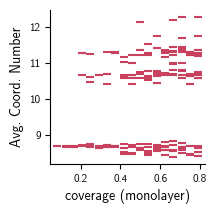

In [9]:
fig, ax = plt.subplots(figsize=(2, 2))

subdf = cndf.loc[(cndf["rank"] == "low") & (cndf["facet"] == 410)]
ax.scatter(
    subdf["cov"],
    subdf["cn"],
    c=SAMPLED,
    marker="_",
)


ax.set_xlabel("coverage (monolayer)")
ax.set_ylabel("Avg. Coord. Number")

# savefig(fig, "05-cn-410-lowe.pdf")
plt.show()

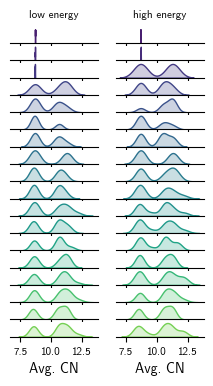

In [10]:
num_plots = len(cndf.loc[cndf["facet"] == 410]["n"].unique())
norm = plt.Normalize(0.0, 1.0)
cmap = lambda _x: cm.viridis(norm(_x))

fig, axs = plt.subplots(num_plots, 2, figsize=(2.5, 4), sharex=True)

subdf = cndf.loc[(cndf["rank"] == "low") & (cndf["facet"] == 410)]
for (ax, (cov, grp)) in zip(axs[:, 0].ravel(), subdf.groupby("cov")):
    sns.kdeplot(
        grp["cn"],
        color=cmap(cov),
        ax=ax,
        fill=True,
        bw_adjust=0.5,
    )
    
subdf = cndf.loc[(cndf["rank"] == "high") & (cndf["facet"] == 410)]
for (ax, (cov, grp)) in zip(axs[:, 1].ravel(), subdf.groupby("cov")):
    sns.kdeplot(
        grp["cn"],
        color=cmap(cov),
        ax=ax,
        fill=True,
        bw_adjust=0.5,
    )

for ax in axs.ravel():
    ax.spines["left"].set_visible(False)
    ax.set_ylabel("")
    ax.set_yticks([])
    
axs[0, 0].set_title("low energy", fontsize=8)
axs[0, 1].set_title("high energy", fontsize=8)

for ax in axs[-1, :]:
    ax.set_xlabel("Avg. CN")
    
savefig(fig, "05-relax-kdes.pdf")    
plt.show()